<a href="https://colab.research.google.com/github/chw8207/fastai_pytorch/blob/main/%ED%98%91%EC%97%85%ED%95%84%ED%84%B0%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### GPU 설정

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1273551633587615424
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15208677376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3928215050242909542
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


### 데이터 : 무비렌즈

In [4]:
path = untar_data(URLs.ML_100k)

In [5]:
# 해당 테이블을 열고 내용을 살펴보기
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestap'])
ratings.head()

,user,movie,rating,timestap
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
# SF, 액션, 고전 영화를 나타내는 요소(스타워즈 최신작)
rise_skywalker = np.array([0.98,0.9,-0.9])

In [7]:
# 현대적인 SF영화를 좋아하는 사용자
user1 = np.array([0.9,0.8,-0.6])

In [8]:
# 이 둘의 조합에서 유사성 계산
(user1*rise_skywalker).sum()

2.1420000000000003

In [9]:
# 영화 카사블랑카
casablanca = np.array([-0.99,-0.3,0.8])

In [10]:
# 사용자 조합해서 유사성 계산
(user1*casablanca).sum()

-1.611

### DataLoaers만들기

In [11]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [12]:
# ratings와 결합하기
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestap,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [13]:
# CollabDataLoader()객체 구축
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,214,Angels and Insects (1995),4
1,927,My Best Friend's Wedding (1997),4
2,280,Alien (1979),3
3,226,Raiders of the Lost Ark (1981),4
4,707,"Postino, Il (1994)",3
5,201,Lawrence of Arabia (1962),3
6,504,Field of Dreams (1989),4
7,128,Roman Holiday (1953),5
8,498,"Full Monty, The (1997)",4
9,374,"Associate, The (1996)",4


In [14]:
# 영화와 사용자의 잠재 요소 테이블을 간단한 행렬로 표현하기
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

In [15]:
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [16]:
# 색인 3을 표현하는 원핫 인코딩된 벡터에
# 사용자용 잠재 요소 행렬을 곱함.
one_hot_3 = one_hot(3, n_users).float()
user_factors.t()@one_hot_3

tensor([ 1.4295,  0.2508, -0.7375,  1.5574,  1.2887])

In [17]:
# 행렬의 세 번째 색인에 해당되는 벡터
user_factors[3]

tensor([ 1.4295,  0.2508, -0.7375,  1.5574,  1.2887])

### 밑바닥부터 만드는 협업 필터링

In [18]:
# 클래스 만들어보기
class Example :
  def __init__(self, a) :
    self.a = a
  def say(self, x) :
    return f'Hello {self.a}, {x}'

In [19]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you'

In [20]:
# 점곱 계산하는 모델
class DotProduct(Module) :
  def __init__(self, n_users, n_movies, n_factors) :
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)

  def forward(self, x) :
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users*movies).sum(dim=1)

In [21]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [22]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [23]:
# 모델 학습
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.356354,1.294865,00:07
1,1.119846,1.095703,00:07
2,0.957560,0.981662,00:07
3,0.846520,0.888902,00:07
4,0.772391,0.875306,00:07


In [24]:
# 모델 개선 : 예측 범위 강제(0~5.5)
class DotProduct(Module) :
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)) :
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  def forward(self, x) :
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users*movies).sum(dim=1), *self.y_range)

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.028665,1.014539,00:07
1,0.876843,0.905632,00:07
2,0.677125,0.871316,00:07
3,0.487533,0.875852,00:07
4,0.374863,0.880406,00:07


In [25]:
# 모델 수정하기(편향도 고려)
class DotProduct(Module) :
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)) :
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range

  def forward(self, x) :
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users*movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return sigmoid_range(res, *self.y_range)

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.948395,0.931527,00:09
1,0.849440,0.867518,00:09
2,0.614178,0.867362,00:08
3,0.422252,0.892714,00:08
4,0.292110,0.899085,00:08


#### 가중치 감쇠(L2정규화)

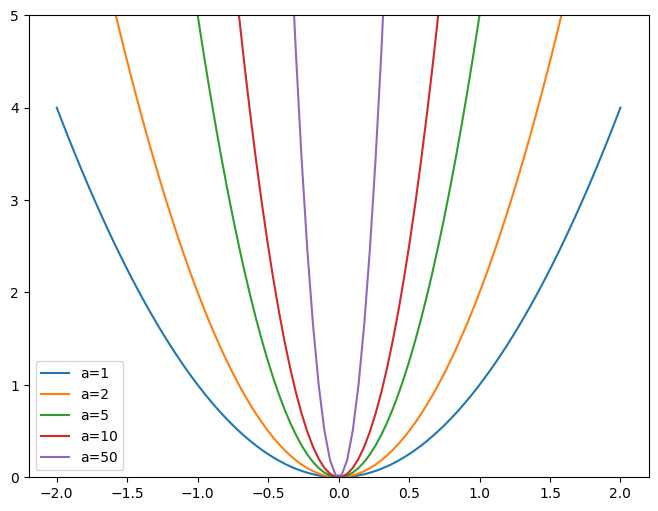

In [26]:
# 그래프 예시
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50]
ys = [a*x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s, ys) :
  ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend()
plt.show();

In [27]:
# 가중치 감쇠 : wd 사용
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.942100,0.943301,00:08
1,0.847616,0.872380,00:08
2,0.728205,0.835666,00:08
3,0.599504,0.819006,00:08
4,0.485550,0.818482,00:08


#### 나만의 임베딩 모듈

In [28]:
class T(Module) :
  def __init(self) :
    self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [29]:
# nn.Parameter 클래스로 래핑하기
class T(Module) :
  def __init__(self) :
    self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [30]:
class T(Module) :
  def __init__(self) :
    self.a = nn.Linear(1,3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[ 0.1760],
        [-0.8419],
        [-0.1343]], requires_grad=True)]

In [31]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [32]:
# 명시적으로 임의 초기화된 텐서를 파라미터로 생성하기
def create_params(size) :
  return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

In [33]:
# 이를 이용하여 DotProductBias 만들어보기
class DotProductBias(Module) :
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)) :
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x) :
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users*movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res, *self.y_range)

In [34]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.933915,0.940234,00:08
1,0.820747,0.866616,00:08
2,0.714424,0.829832,00:08
3,0.585959,0.815667,00:08
4,0.485932,0.816754,00:08


### 임베딩과 편향의 분석

In [35]:
# 가장 낮은 편향 벡터 값의 영화 목록
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Crow: City of Angels, The (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Robocop 3 (1993)',
 '3 Ninjas: High Noon At Mega Mountain (1998)']

In [36]:
# 가장 높은 편향 벡터 값의 영화 목록
# movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'L.A. Confidential (1997)']

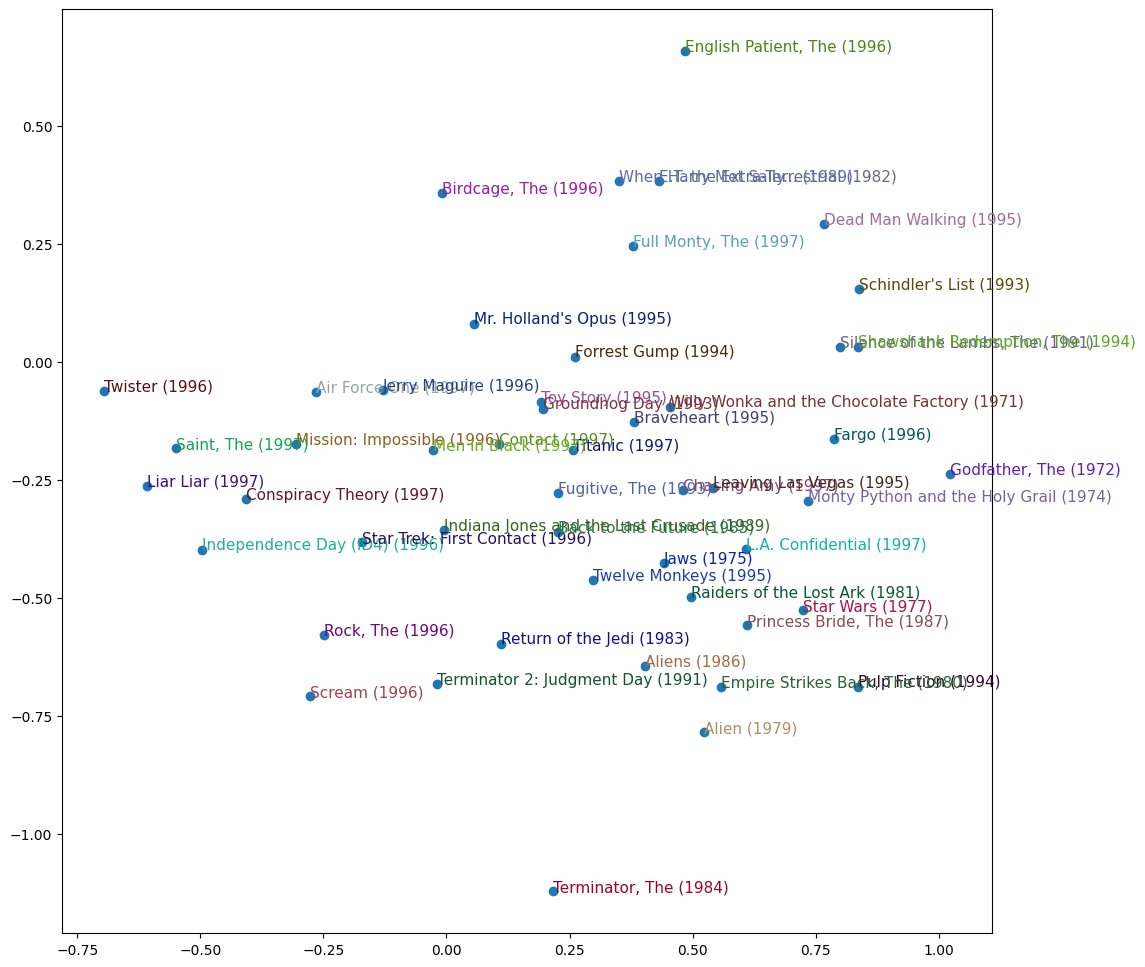

In [54]:
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### fastai.collab 사용하기

In [55]:
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.953580,0.950099,00:08
1,0.859334,0.873794,00:08
2,0.739602,0.829869,00:08
3,0.603651,0.816341,00:08
4,0.502110,0.815885,00:08


In [56]:
# 모델 출력하기
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [57]:
# 상위 5개 영화 출력
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Good Will Hunting (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)']

#### 임베딩 거리

In [63]:
# '양들의 침묵'과 가장 유사한 영화를 찾는 방법
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Entertaining Angels: The Dorothy Day Story (1996)'

### 협업 필터링을 위한 딥러닝

In [64]:
# 임베딩 행렬에 권장되는 크기 반환
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [67]:
# 협업 필터링을 위한 딥러닝 모델 구현
class CollabNN(Module) :
  def __init__(self, user_sz, item_sz, y_range=(0,5.5),n_act=100) :
    self.user_factors = Embedding(*user_sz)
    self.item_factors = Embedding(*item_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1]+item_sz[1], n_act),
        nn.ReLU(),
        nn.Linear(n_act, 1)
    )
    self.y_range = y_range

  def forward(self, x) :
    embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
    x = self.layers(torch.cat(embs, dim=1))
    return sigmoid_range(x, *self.y_range)

In [69]:
# 구성된 클래스와 권장된 임베딩 행렬의 크기로 모델을 생성하기
model = CollabNN(*embs)

In [71]:
# 학습 확인
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.946026,0.939409,00:13
1,0.890778,0.901179,00:09
2,0.848521,0.869121,00:09
3,0.789834,0.861663,00:09
4,0.724393,0.864618,00:09


In [72]:
# fastai로 사용하기
learn = collab_learner(dls, use_nn=True, y_range=(0,5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.972790,1.003210,00:11
1,0.904072,0.908682,00:10
2,0.870923,0.881939,00:10
3,0.810781,0.854952,00:10
4,0.775549,0.856307,00:10


In [73]:
# EmbeddingNN 클래스 구현체
@delegates(TabularModel)
class EmbeddingNN(TabularModel) :
  def __init__(self, emb_szs, layers, **kwargs) :
    super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)